In [1]:
from matplotlib import pyplot as plt
import numpy as np
import skimage, skimage.morphology, skimage.feature
%matplotlib inline

Computes a homogeneous line vector from the $\rho$, $\theta$ parameters returned by SKImage's Hough transform

In [2]:
def homline(rho, theta):
    return [np.cos(theta), np.sin(theta), -rho]

Returns intersection of two homogeneous lines

In [3]:
def homintersect(l1, l2):
    p = np.cross(l1, l2)
    if p[2] != 0:
        p = p/p[2]
    return p

Produces an image of the same shape given as second parameter, representing the geometrical locus of the predicate in the first parameter: the image is 1 if the predicate holds, 0 otherwise.

In [4]:
def locus_imshape(pred, shape):
    return np.array([[1.0 if pred(x, y) else 0.0 for x in range(0, shape[1])] for y in range(0, shape[0])])

In [5]:
def find_table(pic, cannysigma=8, closure=8, threshold_stepback=1):
    hsvpic = skimage.color.rgb2hsv(pic)
    bwpic = hsvpic[:,:,2]
    satpic = hsvpic[:,:,1]
    # White is high-valued and low-saturated, so whiteness of colors is taken to be
    # directly correlated with value and inversely with saturation.
    whitepic = bwpic - satpic
    
    # The histogram should be somehow U-shaped, so the threshold is computed by taking
    # density maximum above the antimode, and then stepping back by a certain proportion
    # of the standard deviation.
    density, edges = np.histogram(whitepic.flat, bins = 40)
    # mean = np.mean(whitepic)
    antimode = skimage.filters.threshold_otsu(whitepic)
    sigma = np.std(whitepic)
    stepback = 0.5
    split = np.searchsorted(edges, antimode, side='right')
    maxd = split + np.argmax(density[split:])
    threshold = edges[maxd] - threshold_stepback*sigma
    maskpic = whitepic > threshold
    
    # The largest connected region will be selected at the table.
    # In order to disconnect nearby bright background region, Canny edges computed on
    # the hue channel (hue is chosen because we already know there wasn't enough distance
    # in brightness).
    huepic = hsvpic[:,:,0]
    cannyhue = skimage.feature.canny(huepic, sigma=cannysigma)
    # satpic = hsvpic[:,:,1]
    # cannysat = skimage.feature.canny(satpic, sigma=cannysigma)
    huesatmask = maskpic & ~cannyhue # & ~cannysat
    labeledpic = skimage.measure.label(huesatmask, connectivity=1)
    largestmask = labeledpic == np.argmax(np.bincount(labeledpic.flat)[1:])+1
    
    # A closure is computed on the mask to clean out speckles and dirt. 
    disk = skimage.morphology.disk(closure)
    return skimage.morphology.binary_closing(largestmask, selem=disk)

In [6]:
# All points are returned in homogeneous pixel coordinates
def vps_corners_and_center_from_tablemask(tablemask):
    cannypic = skimage.feature.canny(tablemask)
    hres = skimage.transform.hough_line(cannypic)
    threshold = 0.1*np.max(hres[0])
    _, angles, dists = skimage.transform.hough_line_peaks(*hres, num_peaks=4, threshold=threshold, min_distance=100)

    lines = [homline(rho, theta) for rho, theta in zip(dists, angles)]
    assert(len(lines) == 4), f"Should be 4 lines, not {len(lines)}!"

    # Vanishing points are found by assuming that the lines with the closest angles are images of parallel lines.
    # The angle space should be continuous between -pi/2 and pi/2, so we throw the antipodal angles into the mix
    # The indices will be restored by modding by 4
    angles_xt = list(enumerate(np.concatenate((angles, angles+np.pi))))
    angle_cpls = [((i, x), (j, y)) for i, x in angles_xt for j, y in angles_xt if i<j]
    # The angles are the second elements of each (i, x) tuple in the couple
    mindstcpl = min(angle_cpls, key=lambda ix_jy: abs(ix_jy[0][1]-ix_jy[1][1]))
    par_idcs1 = [mindstcpl[0][0]%4, mindstcpl[1][0]%4]
    par_idcs2 = [i for i in range(4) if i not in par_idcs1]

    # Not very elegant, I know
    vpx = homintersect(lines[par_idcs1[0]], lines[par_idcs1[1]])
    vpy = homintersect(lines[par_idcs2[0]], lines[par_idcs2[1]])

    lines_par1 = [lines[i] for i in par_idcs1]
    lines_par2 = [lines[i] for i in par_idcs2]
    diag1 = np.cross(np.cross(lines_par1[0], lines_par2[0]), np.cross(lines_par1[1], lines_par2[1]))
    diag2 = np.cross(np.cross(lines_par1[0], lines_par2[1]), np.cross(lines_par1[1], lines_par2[0]))
    center = homintersect(diag1, diag2)

    A = homintersect(lines_par1[0], lines_par2[0])
    B = homintersect(lines_par1[0], lines_par2[1])
    C = homintersect(lines_par2[0], lines_par1[1])
    
    return vpx, vpy, A, B, C, center

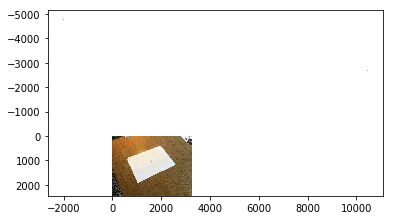

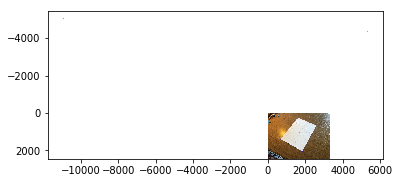

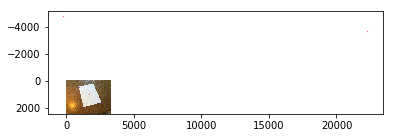

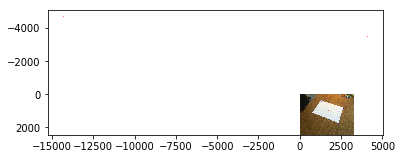

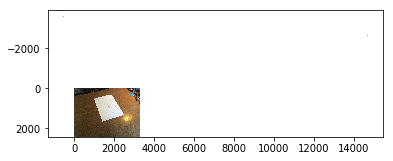

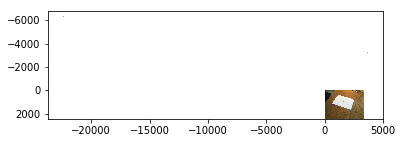

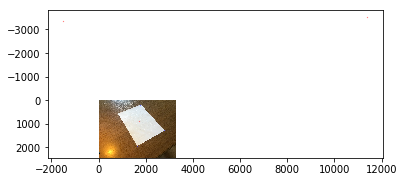

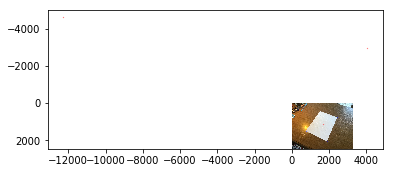

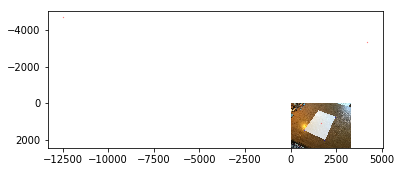

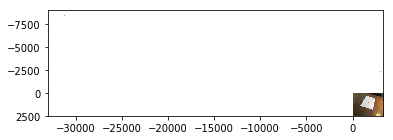

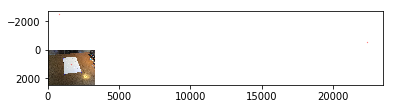

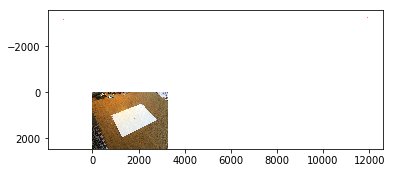

In [10]:
with open("checkers_fullsize/outs.csv", "w") as ofile:
    for i in range(1, 13):
        pic = plt.imread(f"checkers_fullsize/0{i}.jpg")
        tablemask = find_table(pic, closure=16)
        vpx, vpy, A, B, C, center = vps_corners_and_center_from_tablemask(tablemask)
        line = ",".join(map(str, [*vpx, *vpy, *A, *B, *C, *center]))
        ofile.write(line+"\n")
        
        plt.figure(f"Image 0{i}")
        plt.imshow(pic)
        reds = [vpx, vpy, center]
        blues = [A, B, C]
        plt.plot([r[0] for r in reds], [r[1] for r in reds], 'ro',markersize=0.2)
        plt.plot([b[0] for b in blues], [b[1] for b in blues], 'bo',markersize=0.2)
        plt.savefig(f"Image 0{i}", dpi=600)